In [1]:
import pandas as pd
df_timecluster = pd.read_csv("data/ML/ML_Data.csv")

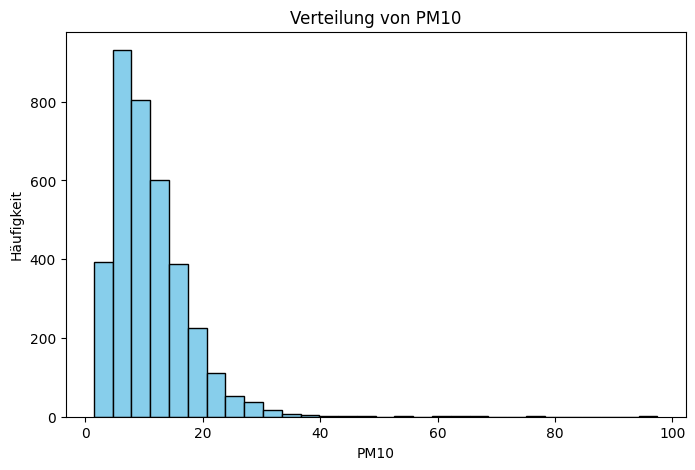

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df_timecluster['PM10'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('PM10')
plt.ylabel('Häufigkeit')
plt.title('Verteilung von PM10')
plt.show()



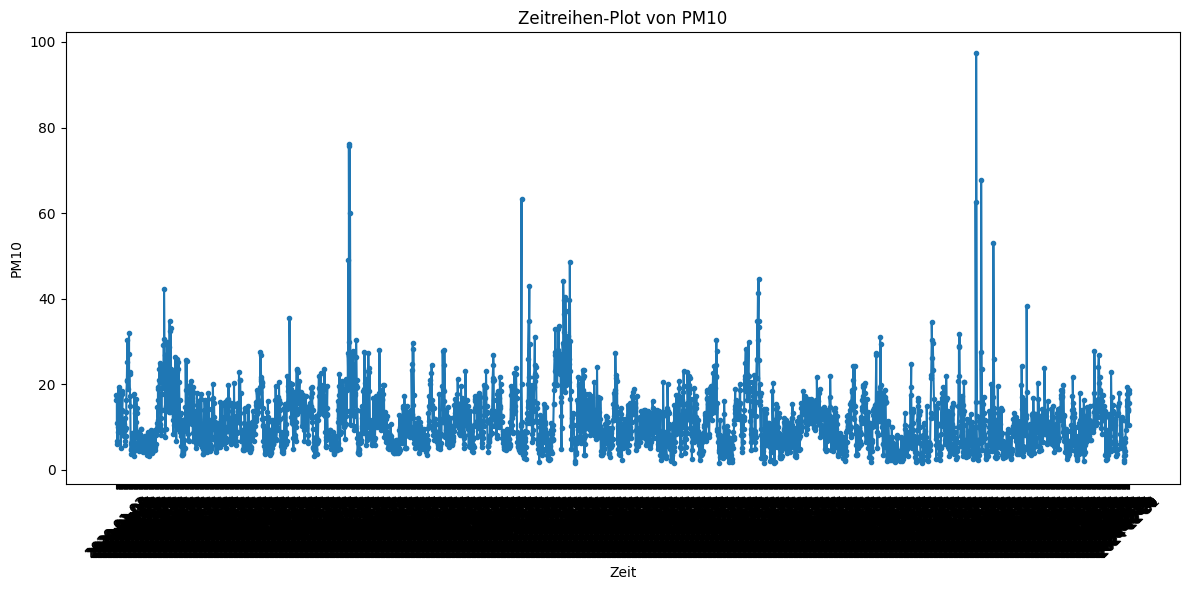

In [4]:
plt.figure(figsize=(12,6))
plt.plot(df_timecluster['date'], df_timecluster['PM10'], marker='.', linestyle='-')
plt.xlabel('Zeit')
plt.ylabel('PM10')
plt.title('Zeitreihen-Plot von PM10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


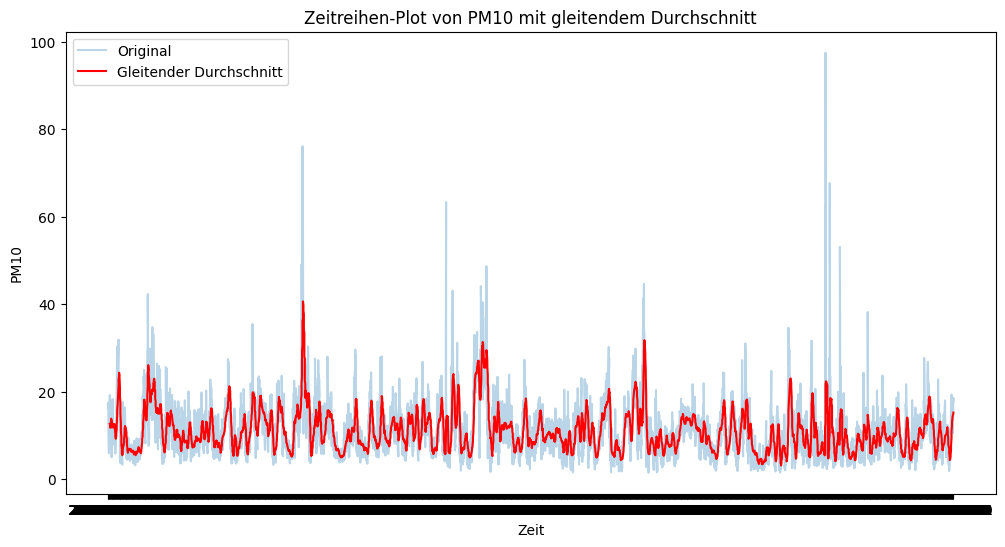

In [9]:
df_timecluster['PM10_rolling'] = df_timecluster['PM10'].rolling(window=10).mean()

plt.figure(figsize=(12,6))
plt.plot(df_timecluster['date'], df_timecluster['PM10'], alpha=0.3, label='Original')
plt.plot(df_timecluster['date'], df_timecluster['PM10_rolling'], color='red', label='Gleitender Durchschnitt')
plt.xlabel('Zeit')
plt.ylabel('PM10')
plt.title('Zeitreihen-Plot von PM10 mit gleitendem Durchschnitt')
plt.legend()
plt.show()